## Предобработка данных

In [3]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd

In [6]:
# Загрузим набор данных

df = pd.read_csv('/content/drive/MyDrive/мои временные ряды/freMPL-R.csv', low_memory=False)  # путь к файлу пишем свой
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

В первом уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [7]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [8]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [10]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [11]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [12]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

In [13]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [14]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [15]:
df = pd.concat([df, VU_dummies], axis=1)

Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [16]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [17]:
SocCatSize = pd.DataFrame(df.groupby('SocioCateg').size().sort_values(), columns=['Frequency'])
SocCatSize

,Frequency
SocioCateg,
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [18]:
df = pd.concat([df, pd.get_dummies(df.SocioCateg)], axis=1)

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [19]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [20]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,1,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,0,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [21]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [22]:
ClaimsCountGroup = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Policies'])
ClaimsCountGroup

,Policies
ClaimsCount,
0.0,104286
1.0,3339
2.0,3529
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6


In [ ]:
import plotly.express as px
fig = px.scatter(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
fig.show()

Уменьшаю число меток (классов до 5)

In [53]:
df.loc[df.ClaimsCount>4, 'ClaimsCount'] = 4
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run,CSP1,CSP2,CSP3,CSP4,CSP5,CSP6,CSP7,DrivAgeSq,ClaimsCount
0,0.083,332,0,0,46,0,50,0.0,0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116,0.0
1,0.916,333,0,0,46,0,50,0.0,0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116,0.0
2,0.550,173,0,0,32,0,68,0.0,0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,1024,0.0
3,0.089,364,1,0,52,0,50,0.0,0,0.0,8.0,0,1,0,0,0,0,0,0,1,0,0,2704,0.0
4,0.233,426,0,0,57,0,50,0.0,0,0.0,7.0,1,0,0,0,0,0,0,0,0,1,0,3249,0.0


In [54]:
ClaimsCountGroup = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Policies'])
ClaimsCountGroup

,Policies
ClaimsCount,
0.0,104286
1.0,3339
2.0,3529
3.0,2310
4.0,1691


## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [24]:
from sklearn.model_selection import train_test_split

In [66]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.30, random_state=1)
x_train_ac, x_valid_ac, y_train_ac, y_valid_ac = train_test_split(x_train_ac, y_train_ac, test_size=0.15, random_state=1)

In [67]:
import xgboost as xgb
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

### * Домашнее задание: Многоклассовая классификация

### Построение модели градиентного бустинга для числа страховых случаев в мультиклассе


Мультиклассификатор строится как softmax коллекция классификаторов
каждуй отвечает на один вопрос - насколько сильно входной пример похож на целевой класс этого классификатора. Результаты взвешиваем софтмаксом


def softmax(x):

    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)







*   Для обучения по софтмаксу построены функции потерь и метрики (они есть  и включатся при определении типа задачи автоматически)
*   При формировании описания задачи мультиклассового типа нужно указать параметр  num_class = <число классов>
*   В xgboost мультиклассы должны быть обозначены в стиле range т.е. от 0 до  num_class-1.
*   Если меток какого-то класса нет в  данных для обучения, то ошибка




Настройка по hyperopt:
 - задать области поиска параметров (смотрим  какую модель строим и пишем ее параметры (даже у xgboosta есть несколько разных вариантов, но мы делали по умолчанию - базовые деревья )). Параметры выбираем по докам модели, которую оптимизируем
 - строим функцию оценки модели - она должна содержать внешний критерий модели - f1, AUC  или еще что-то
 - выбираем механизм поиска (у нас дерево Парзена)
 - задаем число актов поиска - не очень много - это долгий процесс
 - получаем результат работы поиска как лучшие параметры




In [68]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac, y_train_ac)
valid_ac = xgb.DMatrix(x_valid_ac, y_valid_ac)
test_ac = xgb.DMatrix(x_test_ac, y_test_ac)

В примерах должны быть 5 классов.

Это нужно проверить

In [69]:
print(np.unique(train_ac.get_label()))
print(np.unique(test_ac.get_label()))
print(np.unique(valid_ac.get_label()))

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


In [113]:
# Зададим функцию оценки модели для мультиклассовой модели

# кастомная метрика (тут она собственно простая : равен не равен)
# метрика может решать любые удобные нам вопросы (например не учитывать какой-то вариант как ошибку )
# Метрика должна учесть специфику задачи
# принимает 2 набора на вход : целевое состояние и состояние выхода модели для каждого примера 
# это не функция потерь (для нее нужно найти градиент и Гессиан) - это просто метрика результата
def xgb_eval(yhat, dtrain):   
    # ответ модели на входный примеры (тип примеров : тесты или трейны )
    y = dtrain.get_label()
    #  как-то вычисляем потери (можно так, можно паостроить вероятностные потери - logloss)
    errors = np.zeros(y.shape[0])
    errors[y != yhat] = 1.0
    # 
    return 'dev_myerror', np.sum(errors) / y.shape[0]



In [114]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE
# задача этой функции как угодно , но определить метрику качества модели (сравнивать модели будем по ней)
# Обычно - нежно провести обучение и измерить внешний критерий (какую-то метрику. какую метрику брать, выбираем по тому, что нам нужно от модели)
def objective(params):
    # параметры XGBoosta (https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)
    #   'objective' -  задает тип задачи (тип выходного процесса) - может быть регрессией 'reg' , счетным 'count' - счетный выход (у нас счетный или мультикласс), 'multi' - многоклассовая модель например по softmax , бинарным 'binary' и еще несколько менее простых вариантов
    #  'objective':'multi:softmax' - тип задачи на выходе  - это зависит только от выхода нашей задачи - для нашей классификации можно предположить 'multi:softmax' или его вероятностный аналог 
    # 'subsample' - объем подвыборки обучающих примеров относительно поданной выборки (умолчание 1). если 0,5, то  XGBoost будет случайным образом выбирать половину данных для построения деревьев ( цель - борьба с переобучегнием)
    #  'min_child_weight' - соответствует минимальному количеству экземпляров в узле для принятия решения , что это лист, которое должно быть в каждом узле. 
    #  'colsample_bytree' - коэффициент использования признаков при построении каждого дерева. Если 0.5, то берем половину признаков из списка
    #  'eta' - одно из имен скорости обучения 
    #   'alpha', 'lambda' - параметры регуляризации (L1,L2)
    parameters = {
        'objective': 'multi:softmax', # внутренний критерий берем по умолчанию 
        #(если хотим свой, то пишем функцию потерь, которая должна найти градиент и Гесиан (пример https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_softmax.py))
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],        
        'num_class': 5,  # число классов
    }
    # с этими параметрами запускаем кросвалидационную тренировку
    cv_result = xgb.cv(parameters, train_ac, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0, maximize=False, feval=xgb_eval, early_stopping_rounds=10)
    # делаем оценку модели на тестовом наборе для собственной метрики
    score = cv_result['test-dev_myerror-mean'][-1:].values[0]
    return score

In [115]:
# настраиваем деревья - можно использовать все параметры для управления ростом деревьев в xgboost https://xgboost.readthedocs.io/en/latest/parameter.html
# тут наиболее важные для модели
# Определим границы, в которых будем искать гиперпараметры 
# Это пространство, где ищем лучшее решение по параметрам xgboost классификатора
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
        }

In [116]:
# Оптимизация (количество итераций снижено для ускорения работы)
# objective - просто оценка моделей - внешний критерий
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [18:15<00:00, 21.92s/it, best loss: 0.0943282]


In [129]:
# Оптимальные гиперпараметры 

best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 5  # число классов указываем -  5

best_params

{'alpha': 0.8827148967076968,
 'colsample_bytree': 0.6348733450966486,
 'eta': 0.06453634674262083,
 'lambda': 0.4834306668808368,
 'max_depth': 15,
 'min_child_weight': 48.59171387320076,
 'num_boost_round': 204.0,
 'num_class': 5,
 'objective': 'multi:softmax',
 'subsample': 0.9041821870614744}

In [130]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
# feval=xgb_eval указали на метрику для оценки результата
# evals=[(train_ac, "train"),(valid_ac, "valid")] - задаем список возвращаемых оценок (будем оценивать и трейн и valid)
# early_stopping_rounds=10, evals_result=progress - 10 шагов без улучшения и остановим процесс обучения, показывать прогресс модели
xgb_freq = xgb.train(  params=best_params, dtrain=train_ac, feval=xgb_eval, maximize=False, evals=[(train_ac, "train"),(valid_ac, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

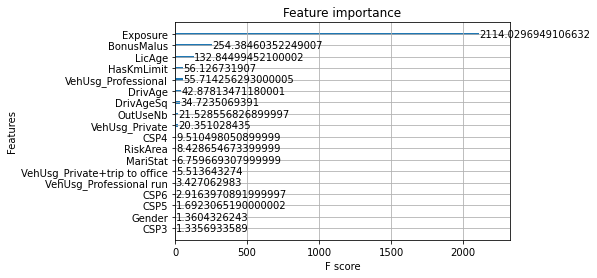

In [132]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[0]); plt.show()

In [156]:
no_w_xgb_test = xgb_freq.predict(test_ac)
no_w_xgb_test = np.asarray([np.argmax(line) for line in no_w_xgb_test])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [158]:
df_test = [ {'set': 'test', 'dmat': test_ac, 'target': y_test_ac}]
for dfset in df_test:
  y_pred = xgb_freq.predict(dfset['dmat'])#np.asarray([np.argmax(line) for line in xgb_riskvar.predict(dfset['dmat'])])
  print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], y_pred, average='micro')) # Посчитаем F1 Score

F1 Score on test: 0.9063883984137552


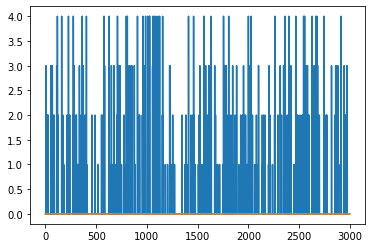

In [164]:
plt.plot(test_ac.get_label()[:3000])
plt.plot(no_w_xgb_test[:3000])
plt.show()

все видит как 0 :(

Добавим веса примеров  в модель

In [134]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size().sort_values(), columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / FreqCount.Count.sum()
FreqCount

,Count,Freq
ClaimsCount,,
4.0,1691,0.014685
3.0,2310,0.020060
1.0,3339,0.028996
2.0,3529,0.030646
0.0,104286,0.905614


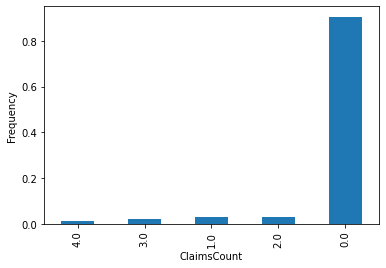

In [135]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [136]:
len(FreqCount)

5

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [137]:
df['weight'] = FreqCount['Freq'][0]
for i in FreqCount.index:
  df['weight'].loc[df.ClaimsCount == i] = 1 - FreqCount['Freq'][i]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [138]:
df['weight']

0         0.094386
1         0.094386
2         0.094386
3         0.094386
4         0.094386
            ...   
115150    0.094386
115151    0.969354
115152    0.094386
115153    0.094386
115154    0.094386
Name: weight, Length: 115155, dtype: float64

In [141]:
col_name = df.drop(['ClaimsCount','ClaimAmount', 'ClaimInd'],axis=1).columns
col_name 


Index(['Exposure', 'LicAge', 'Gender', 'MariStat', 'DrivAge', 'HasKmLimit',
       'BonusMalus', 'OutUseNb', 'RiskArea', 'VehUsg_Private',
       'VehUsg_Private+trip to office', 'VehUsg_Professional',
       'VehUsg_Professional run', 'CSP1', 'CSP2', 'CSP3', 'CSP4', 'CSP5',
       'CSP6', 'CSP7', 'DrivAgeSq', 'weight'],
      dtype='object')

In [142]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score




x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(df.loc[:,col_name], df.ClaimsCount, test_size=0.3, random_state=1)
x_valid_cl, x_test_cl, y_valid_cl, y_test_cl = train_test_split(x_test_cl, y_test_cl, test_size=0.5, random_state=1)


Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [143]:
xgb_train = xgb.DMatrix(x_train_cl.drop('weight', axis = 1), (y_train_cl), weight = x_train_cl.weight)
xgb_valid = xgb.DMatrix(x_valid_cl.drop('weight', axis = 1), (y_valid_cl))
xgb_test = xgb.DMatrix(x_test_cl.drop('weight', axis = 1), (y_test_cl))

Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [144]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK
### Второй вариант оценки модели
def objective(params, n_folds=3):

# Converting pandas dataframe into xgboost format
    d_train = xgb_train

    num_boost_round = int(params['num_boost_round'])
#    metrics = params['metrics']   - родной вариант метрики для многоклассовой классификации по xgboost  

# metrics = 'merror' - используем  умолчания для мультиклассов (он описан и реализован в xgboost)
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round = num_boost_round, 
                        early_stopping_rounds = 10, metrics = 'merror', seed = 0)
  
#  измеряем нашу метрику и вернем ее на уровень сохранения результатов для этой модели 
    loss = min(cv_results['test-merror-mean'])
    return loss

In [145]:
### настраиваем деревья - можно использовать все параметры для управления ростом деревьев в xgboost https://xgboost.readthedocs.io/en/latest/parameter.html
# тут наиболее важные для модели
xgb_space = {
#    max_depth : maximum depth allowed for every tree
# hp.choice.choice will select 1 value from the given list
    'max_depth':hp.hp.choice('max_depth', np.arange(3, 15,1, dtype=int)),
#    subsample : maximum allowed rows for every tree
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
#    colsample_bytree : maximum allowed features for every tree
# hp.hp.quniform returns a float between a given range
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
#    min_child-weight : minimum number of instances required in each node
    'min_child_weight':hp.hp.quniform('min_child_weight', 0, 1000,100),
#    reg_alpha : L1 regularisation term on weights
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1.0),
#    reg_lambda : L2 regularisation term on weights
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1.0),
#    'alpha': hp.hp.uniform('alpha', 0, 1),
#    'lambda': hp.hp.uniform('lambda', 0, 1),
    'eta': hp.hp.uniform('eta', 0.01, 1),
    'num_boost_round': hp.hp.quniform('num_boost_round', 50, 500, 1),
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': len(FreqCount)  # число классов должно соответсвовать выходному признаку 
#    (если нет какой-то из меток, то ошибка, если пропущена метка, то ошибка, если лишняя метка, то ошибка) 
    }

In [146]:
### step 3 : storing the results of every iteration    
bayes_trials = Trials()
MAX_EVALS = 20

# Optimize
best = fmin(fn = objective, space = xgb_space, algo = hp.tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

### best will the return the the best hyperparameter set

100%|██████████| 20/20 [02:48<00:00,  8.42s/it, best loss: 0.5186446666666665]


In [147]:
# Оптимальные гиперпараметры 

best_params = space_eval(xgb_space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] =  5
best_params

{'colsample_bytree': 0.6000000000000001,
 'eta': 0.9626591244334639,
 'max_depth': 6,
 'min_child_weight': 100.0,
 'num_boost_round': 184.0,
 'num_class': 5,
 'objective': 'multi:softmax',
 'reg_alpha': 0.2245840572551151,
 'reg_lambda': 0.082424042022191,
 'subsample': 0.9500000000000001}

Далее обучим нашу модель с оптимальными параметрами

In [148]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()

xgb_count = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), dtrain=xgb_train,
                        params=best_params, evals=[(xgb_train, 'train'),(xgb_valid, 'valid')],
                        early_stopping_rounds=10, evals_result = progress )

[0]	train-merror:0.519402	valid-merror:0.093151
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.519402	valid-merror:0.093151
[2]	train-merror:0.519313	valid-merror:0.093614
[3]	train-merror:0.518317	valid-merror:0.094714
[4]	train-merror:0.51458	valid-merror:0.113761
[5]	train-merror:0.512157	valid-merror:0.120535
[6]	train-merror:0.509897	valid-merror:0.132635
[7]	train-merror:0.508002	valid-merror:0.139119
[8]	train-merror:0.506695	valid-merror:0.140219
[9]	train-merror:0.506053	valid-merror:0.145487
[10]	train-merror:0.505866	valid-merror:0.145198
Stopping. Best iteration:
[0]	train-merror:0.519402	valid-merror:0.093151



In [ ]:
xgb_count.save_model('GB_lesson_3_home_task.model')

In [149]:
preds_xgb_train = xgb_count.predict(xgb_train)
best_preds_xgb_train = np.asarray([np.argmax(line) for line in preds_xgb_train])

In [150]:
preds_xgb_valid = xgb_count.predict(xgb_valid)
best_preds_xgb_valid = np.asarray([np.argmax(line) for line in preds_xgb_valid])

In [151]:
preds_xgb_test = xgb_count.predict(xgb_test)
best_preds_xgb_test = np.asarray([np.argmax(line) for line in preds_xgb_test])

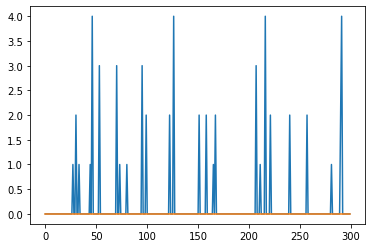

In [161]:
plt.plot(xgb_test.get_label()[:300])
plt.plot(best_preds_xgb_test[:300])
plt.show()

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [153]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [154]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train_cl},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid_cl},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test_cl}]
for dfset in dfsets:
  y_pred = xgb_count.predict(dfset['dmat'])#np.asarray([np.argmax(line) for line in xgb_riskvar.predict(dfset['dmat'])])
  print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], y_pred, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.8591951171099644
F1 Score on valid: 0.8548022925953801
F1 Score on test: 0.8563158504110223


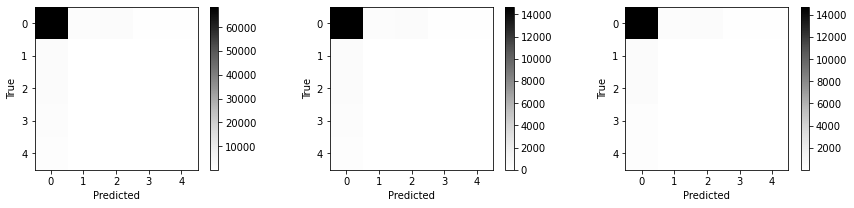

In [155]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_count.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

In [ ]:
#Пока Модель получилась очень плохой - слишком много значений попадают не в свой класс (все опознано как 0),

#Можно попробовать поискать какие-то нелинейные зависимости, по типу квадрата возраста, который был в примере, логарифмической
#или показательной функции, добавив соответствующие показатели в модель.
#Можно каким-то образом поменять функцию ошибки, чтобы она учитывала результаты валидации
